In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
# Load dataset
df = pd.read_csv("Country-data.csv")

print(df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


# EDA

In [ ]:
# Dataset overview
print(df.shape)              
print(df.dtypes)             
print(df.isna().sum())       
print(df.describe().T)

# Check for duplicates
print(f"\nDuplicated raws: {df.duplicated().sum()}")

(167, 10)
country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64
            count          mean           std       min       25%      50%  \
child_mort  167.0     38.270060     40.328931    2.6000     8.250    19.30   
exports     167.0     41.108976     27.412010    0.1090    23.800    35.00   
health      167.0      6.815689      2.746837    1.8100     4.920     6.32   
imports     167.0     46.890215     24.209589    0.0659    30.200    43.30   
income      167.0  17144.688623  19278.067698  609.0000  3355.000  9960.00   
inflation   167.0      7.781832     10.570704   -4.2100     1.810     5.39   
life_expec  167.0     70.555689      

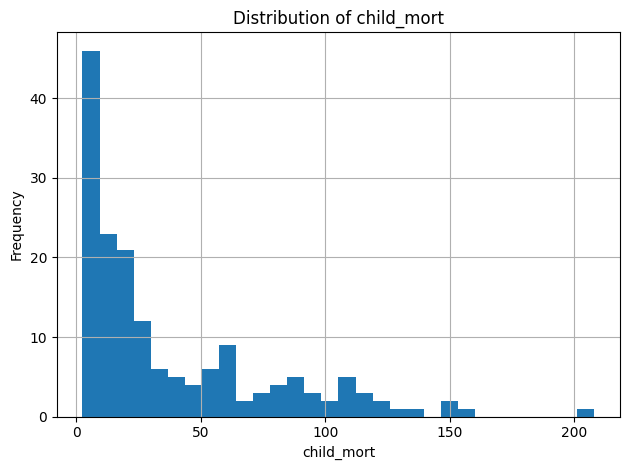

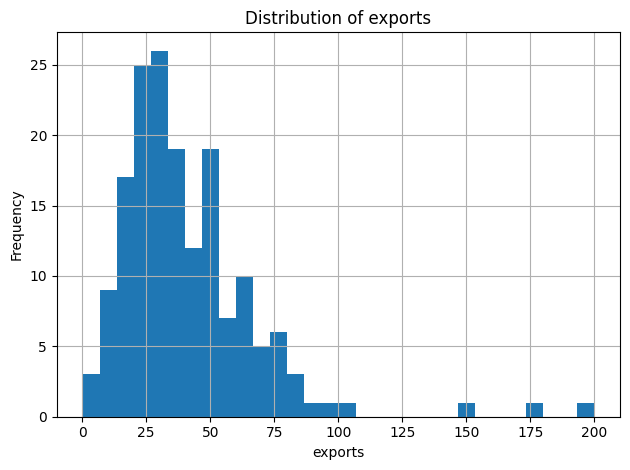

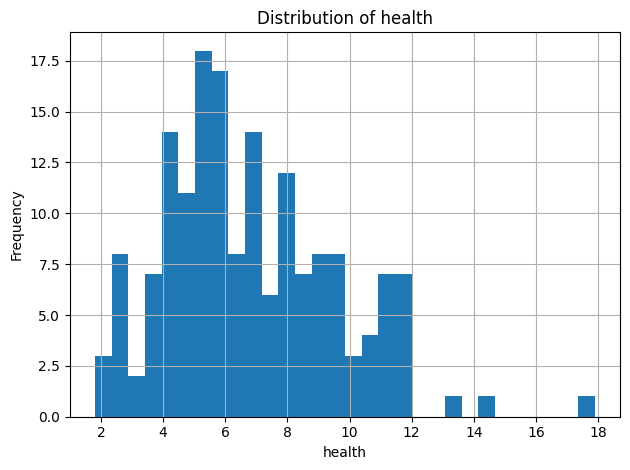

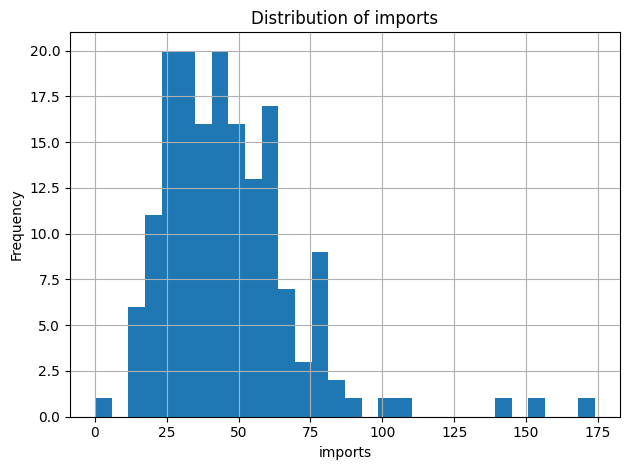

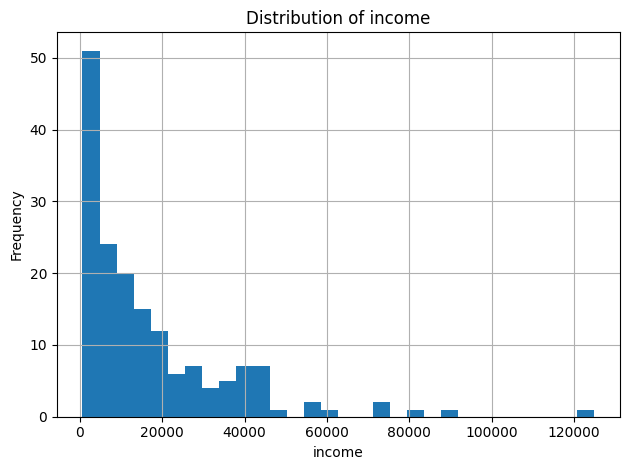

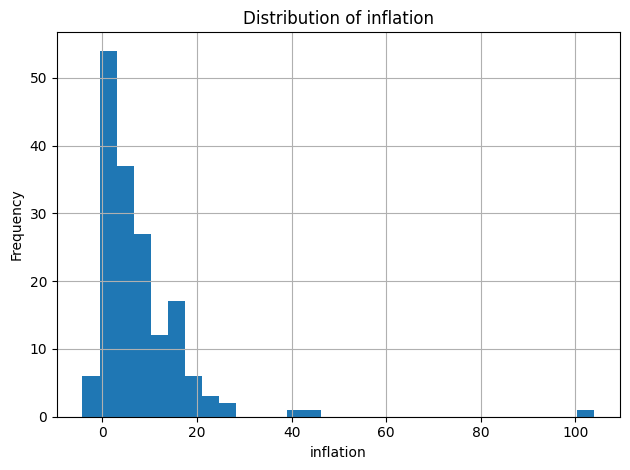

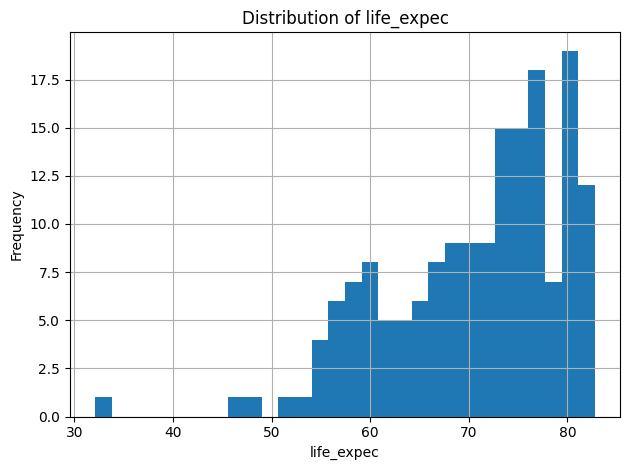

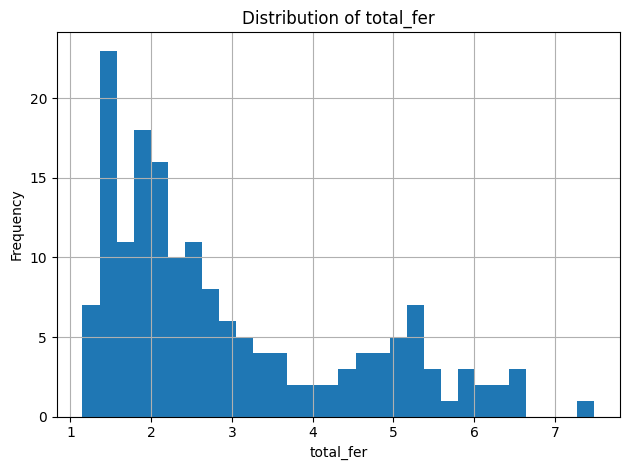

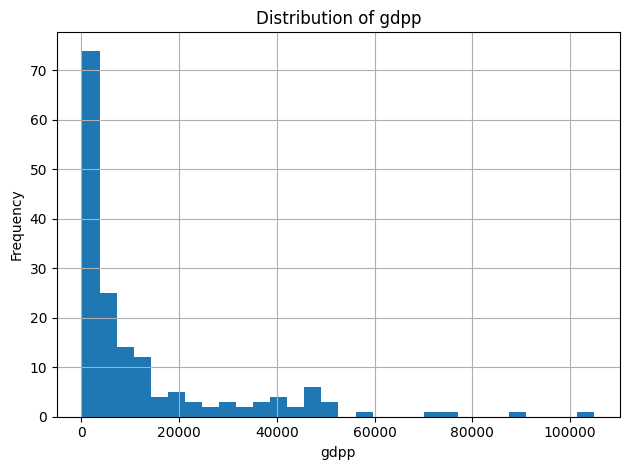

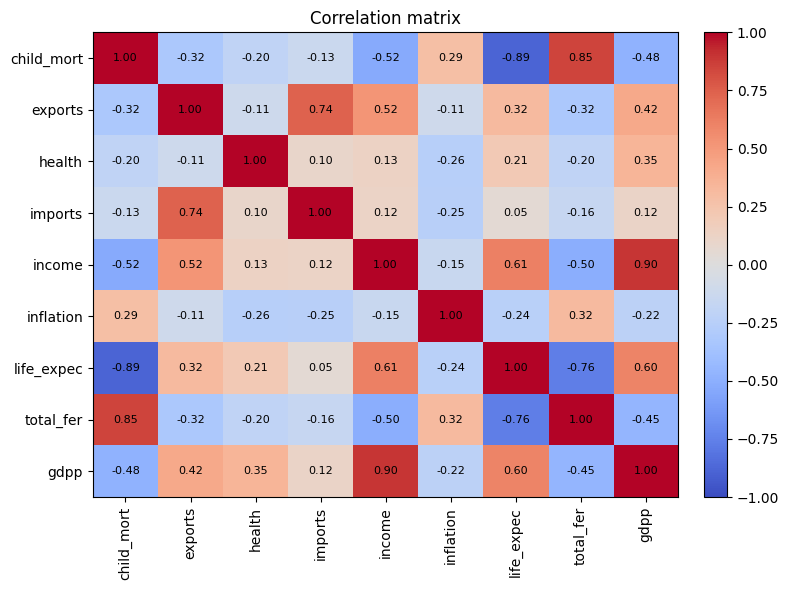

In [4]:
# Histograms of numeric variables
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Correlation heatmap of numeric variables
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation matrix")

# Numeric correlation labels
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        text = f"{corr.iloc[i, j]:.2f}"
        plt.text(j, i, text, ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

# Preprocessing and PCA

In [5]:
# Separation numeric variables from the country identifier
country_names = df['country']     
X = df.drop(columns=['country'])

# Yeo–Johnson transformation on numeric variables
pt = PowerTransformer(method='yeo-johnson')
X_yeo = pt.fit_transform(X)

X_yeo_df = pd.DataFrame(X_yeo, columns=X.columns)

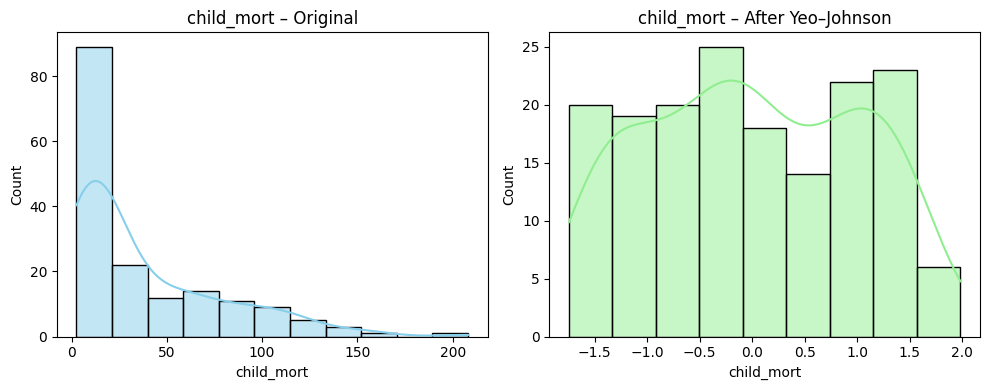

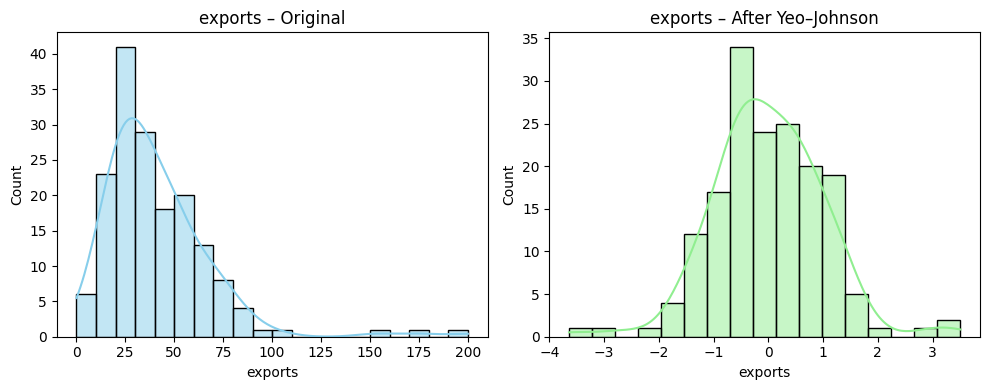

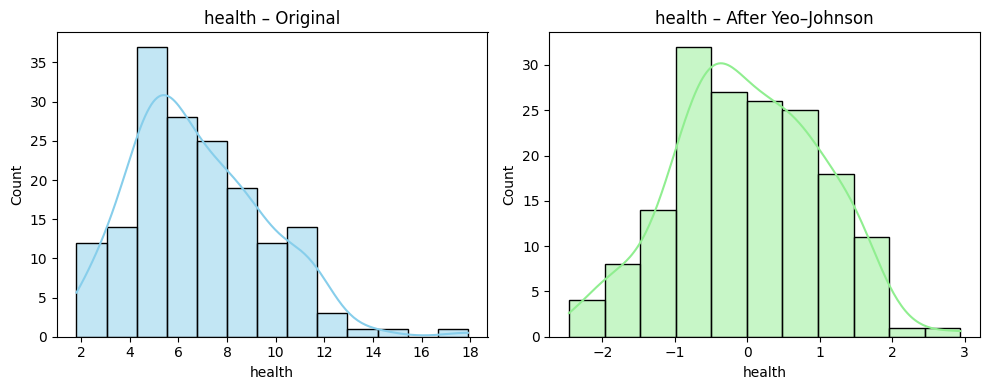

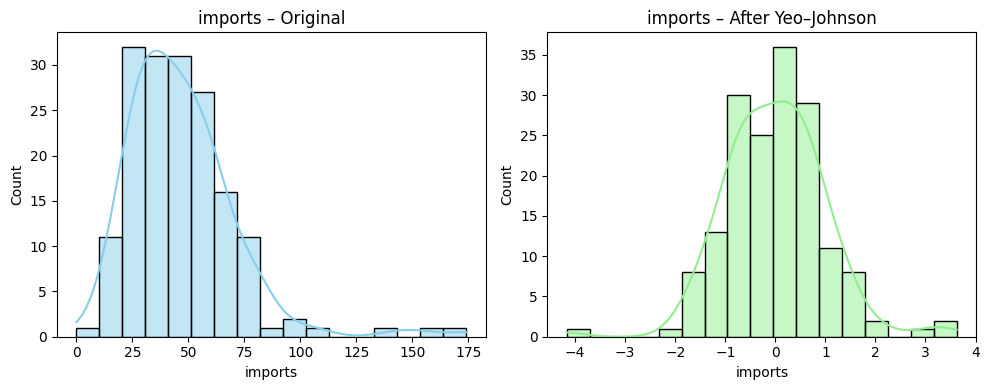

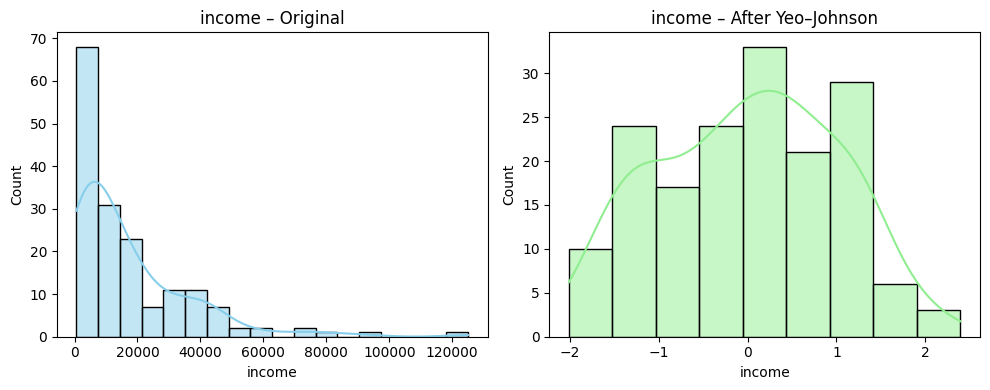

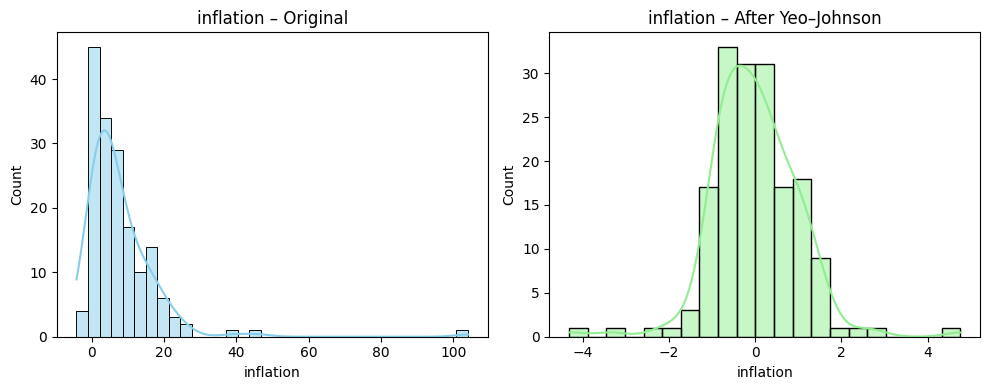

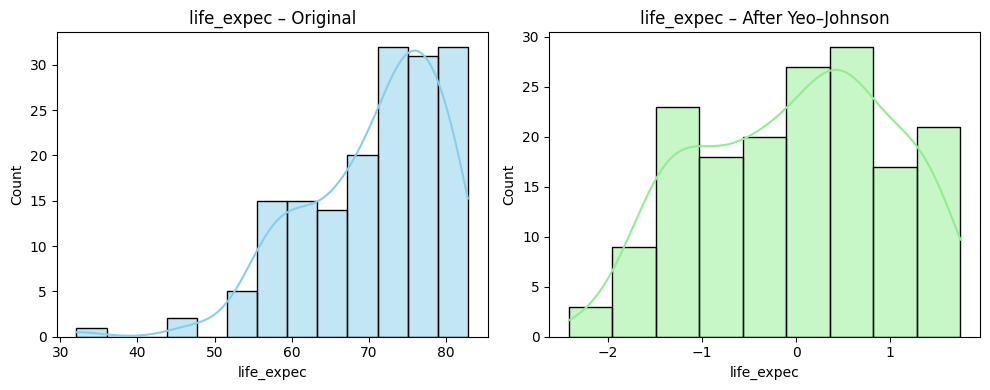

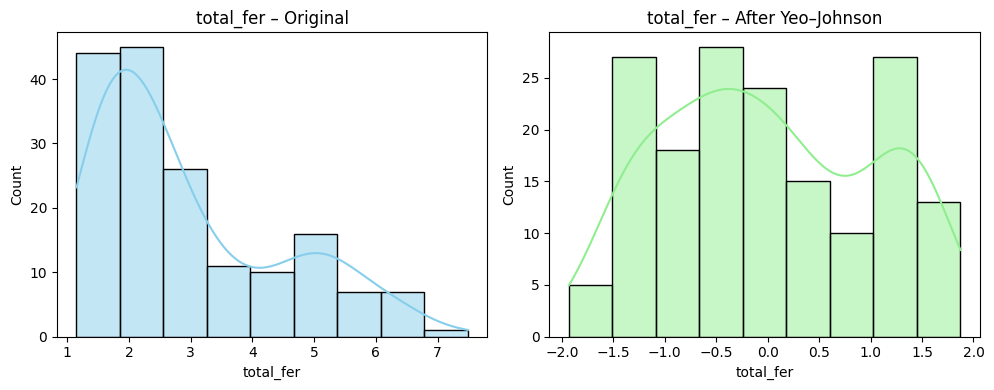

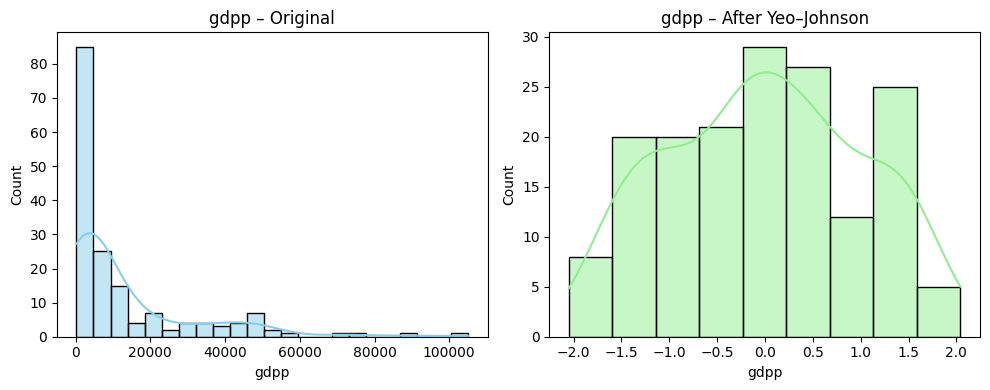

In [6]:
# Visual comparison before/after transformation for each variable
for col in X.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(X[col], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"{col} – Original")

    sns.histplot(X_yeo_df[col], kde=True, ax=axes[1], color='lightgreen')
    axes[1].set_title(f"{col} – After Yeo–Johnson")
    
    plt.tight_layout()
    plt.show()

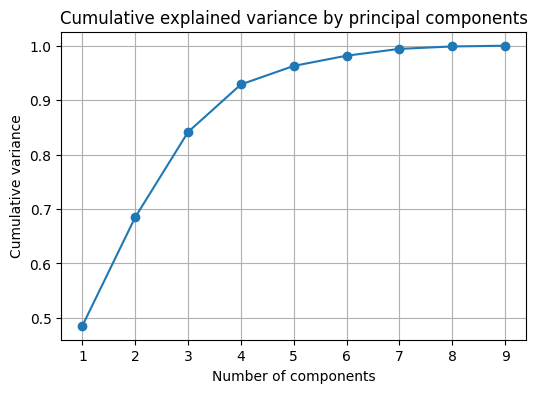

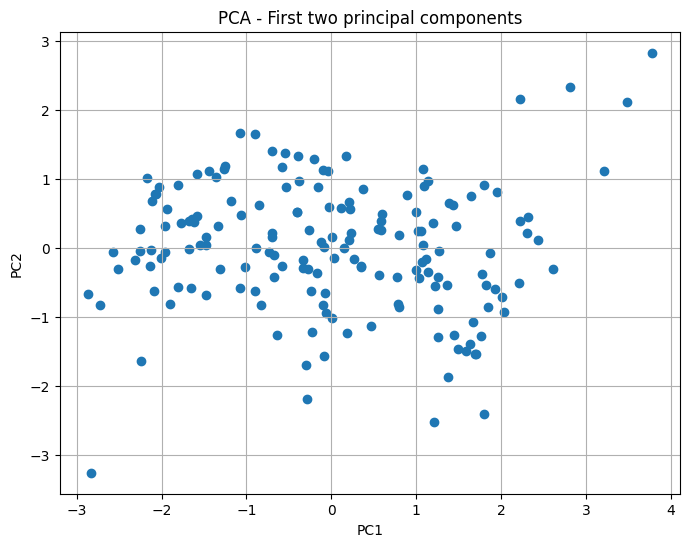

In [7]:
# Robust scaling for numeric variables
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_yeo)

# PCA
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_scaled)

# Cumulative explained variance plot
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Cumulative explained variance by principal components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance')
plt.grid(True)
plt.show()

# PCA 2D visualization
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('PCA - First two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()



# Modeling

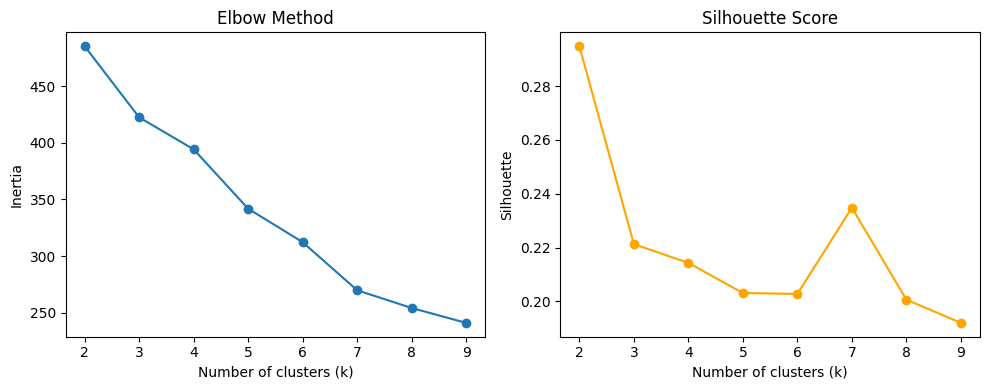

In [8]:

# Search for optimal number of clusters
inertias = []
sil_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow Method and Silhouette Score plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertias, 'o-')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, 'o-', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()



In [9]:
# Select k using Silhouette as criterion
candidate_k = range(3, 7)  
scores = []
models = {}

for k in candidate_k:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    scores.append((k, sil))
    models[k] = (km, labels)

# Choose k with maximum silhouette (break ties by smaller k)
scores = sorted(scores, key=lambda x: (-x[1], x[0]))
best_k = scores[0][0]
kmeans, labels = models[best_k]

print("Silhouette for k:")
for k, s in sorted(scores):
    print(f"  k={k}: silhouette={s:.3f}")
print(f"\n--> chosen k (max silhouette): {best_k}")

Silhouette for k:
  k=3: silhouette=0.221
  k=4: silhouette=0.214
  k=5: silhouette=0.203
  k=6: silhouette=0.203

--> chosen k (max silhouette): 3


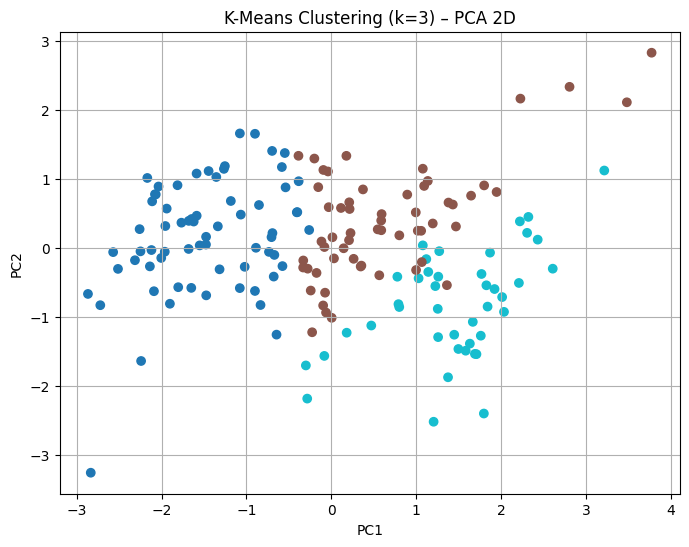

In [10]:
# Silhouette score of the chosen model
optimal_k = 3  

# Final clustering with K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# PCA for cluster visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA 2D visualization of clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.title(f"K-Means Clustering (k={optimal_k}) – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()



In [11]:
# Cluster analysis with mean visualization for each numeric variable
clustered = df.copy()
clustered['cluster'] = labels
num_cols = clustered.select_dtypes(include='number').columns.difference(['cluster'])
cluster_profile = clustered.groupby('cluster')[num_cols].mean().round(2)
print(cluster_profile)


         child_mort  exports      gdpp  health  imports    income  inflation  \
cluster                                                                        
0             74.70    28.18   1887.37    6.11    42.23   3926.01      11.80   
1             18.98    57.93  12599.14    5.68    57.49  22556.90       6.96   
2              6.80    38.51  31138.33    9.51    39.68  30757.62       2.51   

         life_expec  total_fer  
cluster                         
0             62.17       4.39  
1             73.94       2.14  
2             79.26       1.77  


In [12]:
X_raw = df.drop(columns=['country']).copy()

# Robust Need Index
# Higher = more need
# Picking strongly interpretable variables: child_mort (+), total_fer (+), inflation (+) income (-), gdpp (-), life_expec (-)
# Taking out exports/imports; 'health' is %spending/GDP and could be ambiguous
need_vars_pos = ['child_mort', 'total_fer', 'inflation']   # higher = worse
need_vars_neg = ['income', 'gdpp', 'life_expec']           # lower = worse

for col in need_vars_pos + need_vars_neg:
    assert col in X_raw.columns, f"Missing expected column: {col}"

def robust_z(x):
    med = np.median(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    # fallback for too small IQR
    if iqr == 0:
        iqr = np.std(x) if np.std(x) > 0 else 1.0
    return (x - med) / iqr

need_df = pd.DataFrame(index=df.index)

# Positive contributors to need: direct robust z-score
for col in need_vars_pos:
    need_df[col] = robust_z(X_raw[col].values)

# Negative contributors to need: invert sign (low -> high need)
for col in need_vars_neg:
    need_df[col] = -robust_z(X_raw[col].values)

# Weights: default equal;
# optionally boost child_mort and income/gdpp
weights = {
    'child_mort': 1.2,
    'total_fer' : 1.0,
    'inflation' : 0.8,
    'income'    : 1.2,
    'gdpp'      : 1.2,
    'life_expec': 1.2,
}

weighted = []
for col in need_df.columns:
    w = weights.get(col, 1.0)
    weighted.append(w * need_df[col])

need_index = pd.concat(weighted, axis=1).sum(axis=1)
need_index = (need_index - need_index.mean()) / (need_index.std() if need_index.std() > 0 else 1.0)

# Average need score per cluster and selection of the priority cluster
clustered['need_index'] = need_index
cluster_need = clustered.groupby('cluster')['need_index'].mean().sort_values(ascending=False)
priority_clusters = cluster_need.index.tolist()  # ordered by highest need

print("\nAverage need_index per cluster (high = worse):")
print(cluster_need)

top_cluster = priority_clusters[0]
print(f"\nPriority cluster (highest need): {top_cluster}\n")

# Check correlations between need_index and main variables
corr_check = clustered[['need_index','child_mort','total_fer','inflation','income','gdpp','life_expec']].corr()
print(f"Correlation with need_index:\n{corr_check['need_index'].sort_values(ascending=False).round(2)}")



Average need_index per cluster (high = worse):
cluster
0    0.917777
1   -0.308534
2   -1.038002
Name: need_index, dtype: float64

Priority cluster (highest need): 0

Correlation with need_index:
need_index    1.00
child_mort    0.81
total_fer     0.77
inflation     0.44
life_expec   -0.85
income       -0.85
gdpp         -0.86
Name: need_index, dtype: float64


In [21]:
# Ensure clustered and need_index are present
if 'clustered' not in globals():
    clustered = df.copy()
    clustered['cluster'] = labels  # 'labels' comes from KMeans

if 'need_index' not in clustered.columns:
    # If need_index is missing, recreate it from df
    need_vars_pos = ['child_mort', 'total_fer', 'inflation']   # high = worse
    need_vars_neg = ['income', 'gdpp', 'life_expec']           # low = worse
    for col in need_vars_pos + need_vars_neg:
        assert col in df.columns, f"Missing expected column: {col}"

    def robust_z(x):
        med = np.median(x)
        iqr = np.percentile(x, 75) - np.percentile(x, 25)
        if iqr == 0:
            iqr = np.std(x) if np.std(x) > 0 else 1.0
        return (x - med) / iqr

    need_df = pd.DataFrame(index=df.index)
    for col in need_vars_pos:
        need_df[col] = robust_z(df[col].values)
    for col in need_vars_neg:
        need_df[col] = -robust_z(df[col].values)

    weights = {'child_mort':1.2, 'total_fer':1.0, 'inflation':0.8,
               'income':1.2, 'gdpp':1.2, 'life_expec':1.2}
    weighted = [weights.get(c,1.0) * need_df[c] for c in need_df.columns]
    ni = pd.concat(weighted, axis=1).sum(axis=1)
    std = ni.std()
    need_index = (ni - ni.mean()) / (std if std > 0 else 1.0)
    clustered['need_index'] = need_index
else:
    need_index = clustered['need_index']

# Create countries and assign readable cluster names
countries = clustered.copy()
cluster_name_map = {0:"High-priority countries", 1:"Intermediate countries", 2:"Developed countries"}
countries['cluster_name'] = countries['cluster'].map(cluster_name_map)

# Quick check
print(countries[['country','cluster','cluster_name','need_index']].head())

               country  cluster             cluster_name  need_index
0          Afghanistan        0  High-priority countries    1.259488
1              Albania        1   Intermediate countries   -0.143097
2              Algeria        1   Intermediate countries    0.182828
3               Angola        0  High-priority countries    1.461472
4  Antigua and Barbuda        1   Intermediate countries   -0.455699


In [24]:
# Print cluster sizes
print(clustered['cluster'].value_counts().sort_index())



cluster
0    67
1    58
2    42
Name: count, dtype: int64


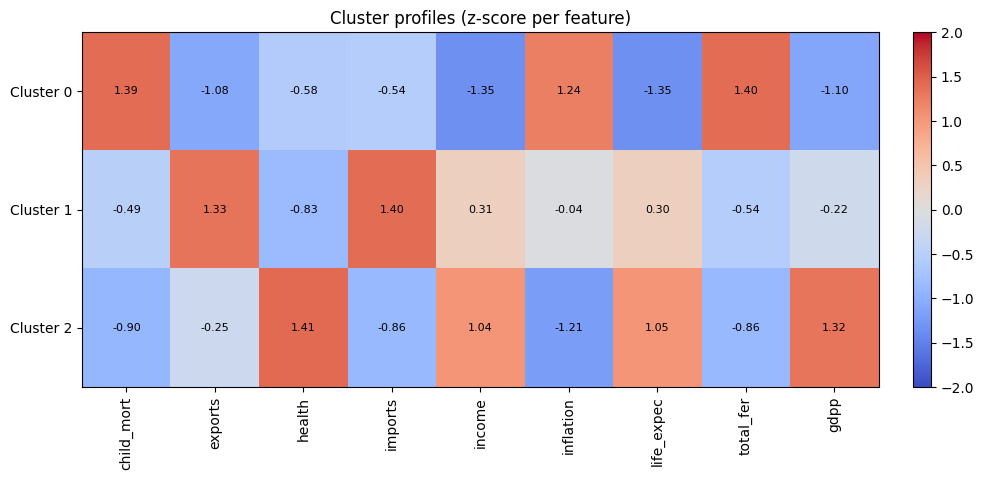

In [25]:
# Normalize to make scales comparable
Z = (cluster_profile - cluster_profile.mean()) / cluster_profile.std(ddof=0)

# Heatmap of cluster profiles (z-score) with numeric values

plt.figure(figsize=(10, 4 + 0.3 * len(Z)))
im = plt.imshow(Z.values, aspect='auto', cmap="coolwarm", vmin=-2, vmax=2)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(Z.shape[1]), Z.columns, rotation=90)
plt.yticks(range(Z.shape[0]), [f"Cluster {c}" for c in Z.index])
plt.title("Cluster profiles (z-score per feature)")

# Add numeric values in each cell
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        text = f"{Z.iloc[i, j]:.2f}"
        plt.text(j, i, text, ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

In [31]:
# Creation of a list of the 10 countries most in need

# Main table with all countries and clusters
countries["rank_global"] = countries["need_index"].rank(ascending=False, method="dense").astype(int)

# Identify the most needy cluster
top_cluster = countries.groupby("cluster")["need_index"].mean().idxmax()
countries["in_priority_cluster"] = countries["cluster"].eq(top_cluster)

# Get top 10 countries by need_index
top_10 = countries[countries['rank_global'].between(1, 10)].sort_values('rank_global')

# Variable columns to show
cols = ['rank_global', 'country', 'cluster_name', 'in_priority_cluster', 'need_index']
cols = [c for c in cols if c in top_10.columns]

# Display the top 10 countries most in need
print("The 10 countries most in need")
print(top_10[cols].to_string(index=False))


The 10 countries most in need
 rank_global                  country            cluster_name  in_priority_cluster  need_index
           1                  Nigeria High-priority countries                 True    2.960620
           2                    Haiti High-priority countries                 True    1.975005
           3             Sierra Leone High-priority countries                 True    1.681863
           4         Congo, Dem. Rep. High-priority countries                 True    1.635420
           5                     Chad High-priority countries                 True    1.528018
           6 Central African Republic High-priority countries                 True    1.522007
           7                   Angola High-priority countries                 True    1.461472
           8                    Niger High-priority countries                 True    1.401687
           9                   Guinea High-priority countries                 True    1.381997
          10        

In [32]:

# FINAL EXPORT FOR REPORTING

# Save main file
countries.to_csv("country_clusters.csv", index=False)
print("Saved country_clusters.csv (for Report)")

# Cluster profiles table (mean per feature)
num_cols = df.select_dtypes(include="number").columns
cluster_profile = countries.groupby("cluster")[num_cols].mean()
Z = (cluster_profile - cluster_profile.mean()) / cluster_profile.std(ddof=0)

# Long format for heatmap
profiles_long = (cluster_profile.reset_index()
                 .melt(id_vars="cluster", var_name="feature", value_name="mean_value"))
Z_long = (Z.reset_index()
          .melt(id_vars="cluster", var_name="feature", value_name="z_score"))
cluster_profiles_long = profiles_long.merge(Z_long, on=["cluster","feature"], how="left")
cluster_profiles_long["cluster_name"] = cluster_profiles_long["cluster"].map(
    countries.set_index("cluster")["cluster_name"].to_dict()
)

cluster_profiles_long.to_csv("cluster_profiles_long.csv", index=False)
print("Saved cluster_profiles_long.csv (cluster profiles heatmap)")


Saved country_clusters.csv (for Report)
Saved cluster_profiles_long.csv (cluster profiles heatmap)
